<a href="https://colab.research.google.com/github/manuelec/nasdaq-prediction-pytorch/blob/main/AutoGluon_Time_Series_Predicting_NASDAQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Creation

In [1]:
# Install yfinance
# !pip install yfinance pandas-datareader

In [2]:
#@title Import libraries
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from google.colab import auth
from google.auth import default
import gspread
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import copy
import torch.nn.utils
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader, TensorDataset

In [3]:
#@title Download Data from yfinance
start_date = "2018-01-02"
end_date = "2024-12-13"

# Download NASDAQ and S&P 500 data from Yahoo Finance
nasdaq_data = yf.download("^IXIC", start=start_date, end=end_date)  # ^IXIC is the ticker for NASDAQ
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)  # ^GSPC is the ticker for S&P 500

# Download Treasury yield and VIX from FRED
treasury_yield = web.DataReader("DGS10", "fred", start_date, end_date)
vix = web.DataReader("VIXCLS", "fred", start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#@title Dataframe preparation
# Rename columns for clarity and to avoid duplicates
nasdaq_data = nasdaq_data.rename(columns={"Close": "nasdaq_close"})
sp500_data = sp500_data.rename(columns={"Close": "sp500_close"})

# Select the correct columns using the MultiIndex
nasdaq_close = nasdaq_data[('nasdaq_close', '^IXIC')]  # Accessing 'nasdaq_close' under 'Price' level and '^IXIC' under 'Ticker' level
sp500_close = sp500_data[('sp500_close', '^GSPC')]  # Accessing 'sp500_close' under 'Price' level and '^GSPC' under 'Ticker' level

# Convert the Series to DataFrames
nasdaq_close = pd.DataFrame(nasdaq_close)
sp500_close = pd.DataFrame(sp500_close)

# Merge the DataFrames
combined_df = nasdaq_close
combined_df = combined_df.join(sp500_close, how="left")

# Reset the index and flatten the MultiIndex columns
combined_df = combined_df.reset_index()
combined_df.columns = combined_df.columns.to_flat_index()

# Rename the columns
combined_df = combined_df.rename(
    columns={
        ("Date", ""): "Date",
        ("nasdaq_close", "^IXIC"): "nasdaq_close",
        ("sp500_close", "^GSPC"): "sp500_close",
    }
)

# Convert 'Date'
combined_df['Date'] = pd.to_datetime(combined_df['Date']).dt.tz_localize(None)

# Join with treasury_yield and vix
combined_df = combined_df.join(treasury_yield, how="left", on="Date")
combined_df = combined_df.join(vix, how="left", on="Date")

# Handle missing values (if any)
combined_df = combined_df.ffill()

# Print and check
print(combined_df.head())

        Date  nasdaq_close  sp500_close  DGS10  VIXCLS
0 2018-01-02   7006.899902  2695.810059   2.46    9.77
1 2018-01-03   7065.529785  2713.060059   2.44    9.15
2 2018-01-04   7077.910156  2723.989990   2.46    9.22
3 2018-01-05   7136.560059  2743.149902   2.47    9.22
4 2018-01-08   7157.390137  2747.709961   2.49    9.52


In [5]:
#@title Enhanced technical indicators
def calculate_rsi(prices, periods=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_bands(prices, window=20, num_std=2):
    rolling_mean = prices.rolling(window=window).mean()
    rolling_std = prices.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

def calculate_macd(prices, fast=12, slow=26, signal=9):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def calculate_atr(prices, periods=14):
    high = prices.rolling(window=periods).max()
    low = prices.rolling(window=periods).min()
    tr = high - low
    return tr.rolling(window=periods).mean()

def create_features(data):
    df = data.copy()

    # Price-based features
    df['log_nasdaq'] = np.log(df['nasdaq_close'])
    df['log_sp500'] = np.log(df['sp500_close'])
    df['nasdaq_returns'] = df['nasdaq_close'].pct_change()
    df['sp500_returns'] = df['sp500_close'].pct_change()

    # Moving averages
    df['nasdaq_ma20'] = df['nasdaq_close'].rolling(window=20).mean()
    df['nasdaq_ma50'] = df['nasdaq_close'].rolling(window=50).mean()
    df['sp500_ma50'] = df['sp500_close'].rolling(window=50).mean()

    # Volatility indicators
    df['nasdaq_volatility'] = df['nasdaq_returns'].rolling(window=21).std()
    df['upper_band'], df['lower_band'] = calculate_bollinger_bands(df['nasdaq_close'])
    df['atr'] = calculate_atr(df['nasdaq_close'])

    # Momentum indicators
    df['rsi'] = calculate_rsi(df['nasdaq_close'])
    df['macd'], df['macd_signal'] = calculate_macd(df['nasdaq_close'])

    # Market relationship indicators
    df['relative_strength'] = df['nasdaq_close'] / df['sp500_close']

    # Fill NaN values
    df = df.bfill()
    df = df.ffill()

    return df

In [6]:
#@title Create enhanced (selected only) features
df = create_features(combined_df)
print(df.columns)

Index(['Date', 'nasdaq_close', 'sp500_close', 'DGS10', 'VIXCLS', 'log_nasdaq',
       'log_sp500', 'nasdaq_returns', 'sp500_returns', 'nasdaq_ma20',
       'nasdaq_ma50', 'sp500_ma50', 'nasdaq_volatility', 'upper_band',
       'lower_band', 'atr', 'rsi', 'macd', 'macd_signal', 'relative_strength'],
      dtype='object')


- uncomment if needed to export to Google Sheet, else leave it

In [7]:
#@title Export to Google Sheet and CSV locally
# # !pip install gspread oauth2client

# # Authenticate and create the Google Sheets connection
# auth.authenticate_user()
# creds, _ = default()
# gc = gspread.authorize(creds)

# # Create a new spreadsheet
# sh = gc.create('Combined_Dataset')

# # Open the spreadsheet
# worksheet = gc.open('Combined_Dataset').sheet1

# # Convert 'Date' column to string before exporting
# combined_df['date'] = combined_df['date'].astype(str)

# # Export the DataFrame to Google Sheets
# worksheet.update([combined_df.columns.values.tolist()] + combined_df.values.tolist())

# # Get the URL of the newly created spreadsheet
# spreadsheet_url = sh.url
# print(f"Spreadsheet URL: {spreadsheet_url}")

# exporting as csv for covenience in local folder
# combined_df.to_csv('./Combined_Dataset.csv', index=False)



---



In [8]:
#@title Dates check
first_date = df['Date'].min()
last_date = df['Date'].max()

# Create a date range representing all business days between the first and last dates
date_range = pd.date_range(start=first_date, end=last_date, freq='B')

# Calculate the number of missing days
missing_days = len(date_range) - len(df)

print(f"First Date: {first_date}")
print(f"Last Date: {last_date}")
print(f"Number of missing days due to business days only: {missing_days}")

First Date: 2018-01-02 00:00:00
Last Date: 2024-12-12 00:00:00
Number of missing days due to business days only: 64


In [17]:
df.shape

(1749, 21)



---



In [9]:
# !pip install autogluon

In [10]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [11]:
# column item_id required by Autogluon
df['item_id'] = 'nasdaq'  # You can use any constant value here

In [12]:
#@title Create the time series dataframe for Autogluon
ts_data = TimeSeriesDataFrame.from_data_frame(
    df=df,
    id_column='item_id',  # If you have multiple time series, otherwise use a constant
    timestamp_column="Date",
)

ts_data = ts_data.convert_frequency(freq="B")

In [18]:
ts_data.shape

(1813, 19)

In [13]:
#@title Set Prediction Length
prediction_length = 30



---



In [14]:
#@title Select features for model input
features = [
       'sp500_close', 'DGS10', 'VIXCLS', 'log_nasdaq',
       'log_sp500', 'nasdaq_returns', 'sp500_returns', 'nasdaq_ma20',
       'nasdaq_ma50', 'sp500_ma50', 'nasdaq_volatility', 'upper_band',
       'lower_band', 'atr', 'rsi', 'macd', 'macd_signal', 'relative_strength'
]

target = 'nasdaq_close'

In [15]:
#@title Set the predictor
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target=target,
    known_covariates_names=features,
    freq="B"  # "B" for business days

)

In [16]:
#@title Fit the predictor and start training
predictor.fit(
    train_data=ts_data,
    num_val_windows=3,
    # presets="medium_quality",  # You can choose from 'best_quality', 'medium_quality', 'low_quality'
    time_limit=1800,  # Time limit in seconds for training
    hyperparameters={
        # "ETS": {},
        "AutoETSModel":{},
        # "ARIMA": {},
        "AutoARIMAModel":{},
        "DeepAR": {},
        "TemporalFusionTransformer": {},
        "TiDEModel":{},
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small",
             "fine_tune": True,
             "target_scaler": "standard",
             "covariate_regressor": "CAT",
             "ag_args": {"name_suffix": "FineTunedWithRegressor"}},
        ]
        }
)

Beginning AutoGluon training... Time limit = 1800s
AutoGluon will save models to '/content/AutogluonModels/ag-20241216_221936'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          0
Memory Avail:       10.79 GB / 12.67 GB (85.1%)
Disk Space Avail:   74.20 GB / 107.72 GB (68.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'B',
 'hyperparameters': {'AutoARIMAModel': {},
                     'AutoETSModel': {},
                     'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTunedWithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'fine_tune

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-0.0257       = Validation score (-WQL)
	26.77   s     = Training runtime
	1.83    s     = Validation (prediction) runtime
Training timeseries model ChronosFineTunedWithRegressor[bolt_small]. Training for up to 352.5s of the 1762.5s of remaining time.
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/AutogluonModels/ag-20241216_221936/models/ChronosFineTunedWithRegressor[bolt_small]/W0/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/AutogluonModels/ag-20241216_221936/models/ChronosFineTunedWithRegressor[bolt_small]/W1/fine-tuned-ckpt
	Fine-tuning on the CPU detected. We recommend using a GPU for faster fine-tuning of Chronos.
	Saving fine-tuned model to /content/AutogluonModels/ag-20241216_221936/models/ChronosFineTunedWithRegressor[bolt_small]/W2/fine-tuned-ckpt
	-0.0202       = Validation score (-WQL)
	340

Covariates management

In [33]:
predictor.leaderboard(ts_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer,-0.003504,-0.006714,0.148711,0.049216,342.391772,5
1,WeightedEnsemble,-0.004396,-0.004148,0.640046,0.326237,3.081669,8
2,DeepAR,-0.009417,-0.006480,0.381227,0.231427,346.303935,6
3,TiDE,-0.011022,-0.016274,0.104934,0.045594,352.591889,7
4,ChronosFineTunedWithRegressor[bolt_small],-0.030578,-0.020180,1.185392,0.241041,340.612399,4
5,AutoETS,-0.033525,-0.026313,0.917642,1.133850,6.562263,1
6,ChronosZeroShot[bolt_small],-0.035718,-0.025731,2.104420,1.831043,26.766983,3
7,AutoARIMA,-0.044101,-0.030930,0.205360,0.284784,0.751397,2


In [20]:
performance = predictor.evaluate(ts_data)
print(performance)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'WQL': -0.004395903940357258}


In [21]:
feature_importance = predictor.feature_importance(ts_data)
print(feature_importance)

Computing feature importance
Subsample_size 50 is larger than the number of items in the data and will be ignored


                   importance     stdev    n   p99_low  p99_high
sp500_close          0.002236  0.000065  5.0  0.002102  0.002369
DGS10               -0.000570  0.000029  5.0 -0.000629 -0.000510
VIXCLS               0.001973  0.000107  5.0  0.001753  0.002193
log_nasdaq           0.005588  0.000050  5.0  0.005486  0.005690
log_sp500            0.039751  0.000018  5.0  0.039714  0.039789
nasdaq_returns       0.003901  0.000052  5.0  0.003795  0.004007
sp500_returns        0.000008  0.000064  5.0 -0.000124  0.000141
nasdaq_ma20          0.001033  0.000034  5.0  0.000962  0.001103
nasdaq_ma50          0.000928  0.000033  5.0  0.000860  0.000997
sp500_ma50           0.030855  0.000060  5.0  0.030732  0.030978
nasdaq_volatility    0.000322  0.000046  5.0  0.000228  0.000415
upper_band           0.000439  0.000080  5.0  0.000275  0.000603
lower_band           0.001317  0.000051  5.0  0.001212  0.001422
atr                  0.000544  0.000040  5.0  0.000461  0.000627
rsi                  0.00

In [22]:
# Access the best model's name
best_model_name = predictor.model_best
print(f"Best Model: {best_model_name}")

Best Model: WeightedEnsemble




---



In [23]:
future_covariates = ts_data.loc[ts_data.index[-prediction_length:]]  # Assuming the last rows are the future known covariates

In [24]:
# Extend the future covariates to cover the prediction length
future_dates = pd.date_range(start=future_covariates.index[-1][1] + pd.Timedelta(days=1), periods=prediction_length, freq="B")

future_covariates_extended = pd.DataFrame(
    index=pd.MultiIndex.from_product([['nasdaq'], future_dates], names=['item_id', 'timestamp']),
    columns=future_covariates.columns,
    data=np.nan
)

In [25]:
# Fill NaN values with the last known values
future_covariates_extended = future_covariates_extended.ffill().bfill()

In [26]:
# Concatenate the original future covariates with the extended ones
future_covariates = pd.concat([future_covariates, future_covariates_extended])

In [27]:
# Make predictions
predictions = predictor.predict(ts_data, known_covariates=future_covariates)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


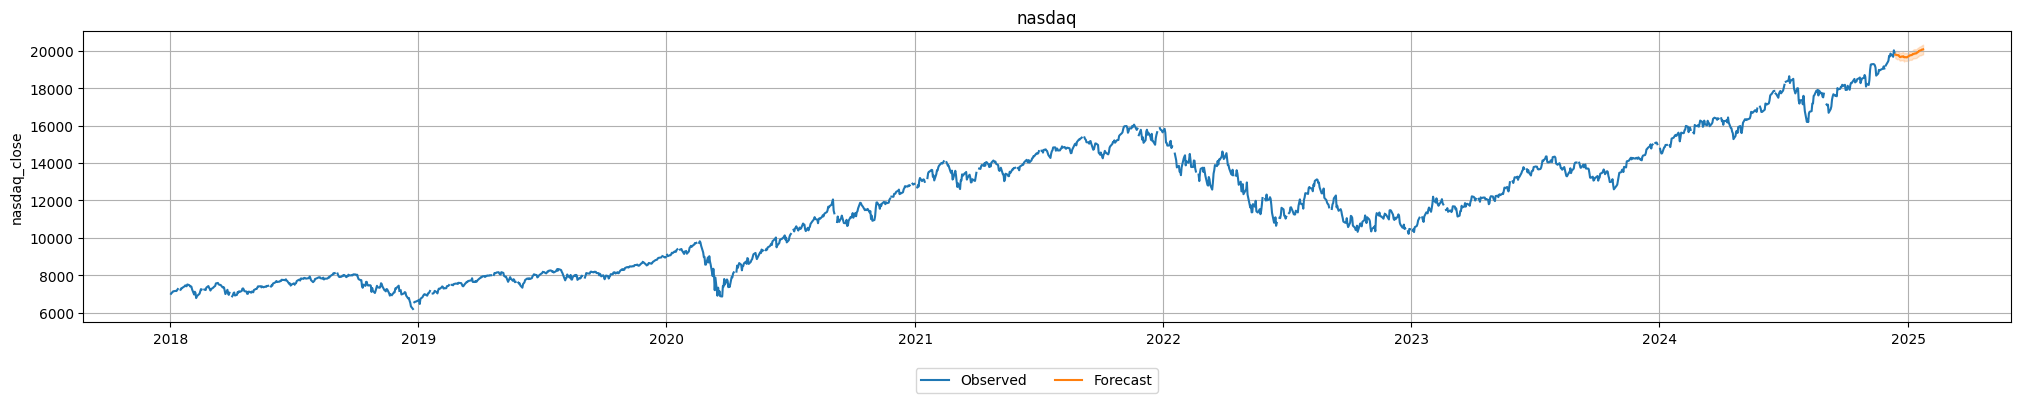

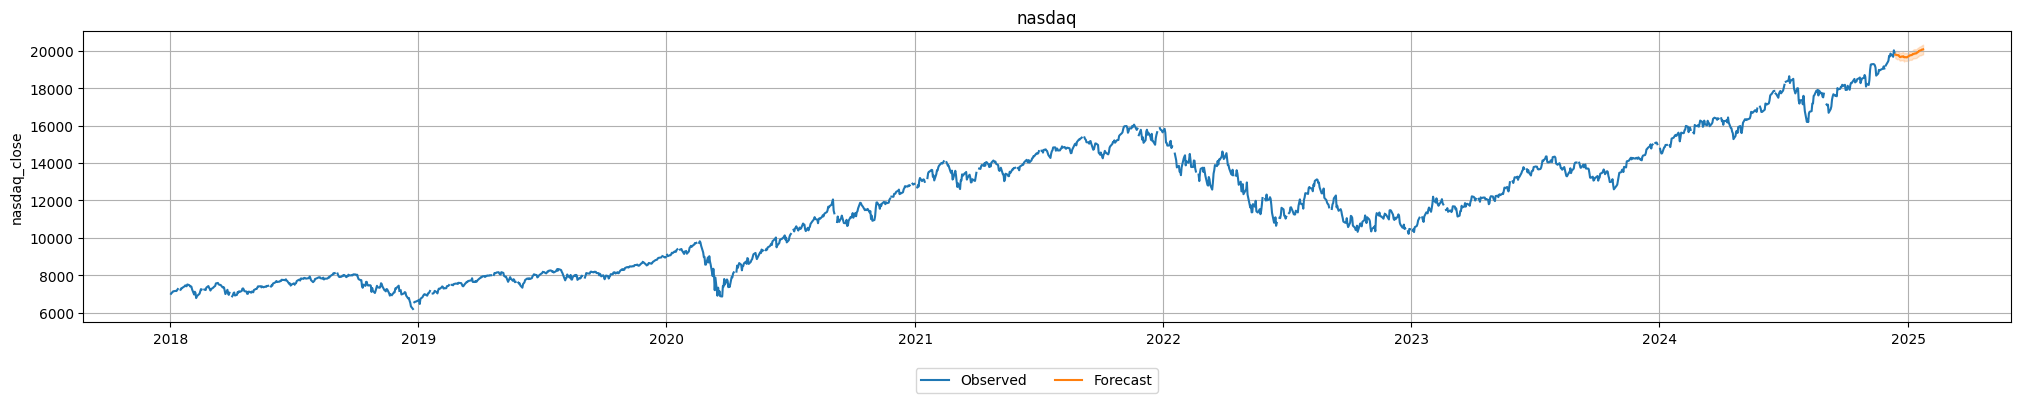

In [29]:
predictor.plot(ts_data,predictions=predictions)

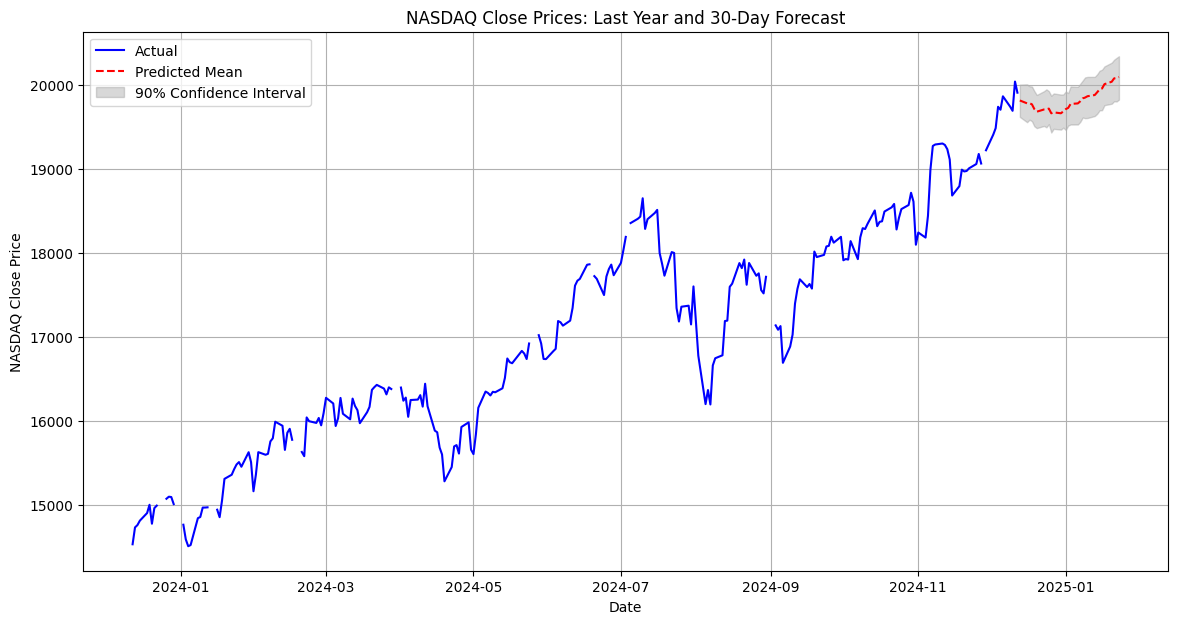

In [30]:
# Filter the last year of actual data
last_year_data = ts_data.loc[ts_data.index.get_level_values('timestamp') >= (ts_data.index.get_level_values('timestamp').max() - pd.DateOffset(years=1))]

# Plot the actual NASDAQ close prices for the last year along with the predicted values and their confidence intervals
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(last_year_data.index.get_level_values('timestamp'), last_year_data['nasdaq_close'], label='Actual', color='blue')

# Plot predicted mean
plt.plot(predictions.index.get_level_values('timestamp'), predictions['mean'], label='Predicted Mean', color='red', linestyle='--')

# Fill confidence interval
plt.fill_between(
    predictions.index.get_level_values('timestamp'),
    predictions['0.1'],
    predictions['0.9'],
    color='gray',
    alpha=0.3,
    label='90% Confidence Interval'
)

# Add titles and labels
plt.title('NASDAQ Close Prices: Last Year and 30-Day Forecast')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Combine the datasets based on the 'Date' index
combined_data = pd.concat([last_year_data['nasdaq_close'], predictions['mean']])

# Reset the index to make 'Date' a regular column
combined_data = combined_data.reset_index()

# Rename the columns for clarity
combined_data.columns = ['item_id','Date', 'Value']

# Add a column to distinguish between actual and predicted values
combined_data['Type'] = 'Actual'
combined_data.loc[combined_data.index >= len(last_year_data), 'Type'] = 'Predicted'

combined_data

,item_id,Date,Value,Type
0,nasdaq,2023-12-12,14533.400391,Actual
1,nasdaq,2023-12-13,14733.959961,Actual
2,nasdaq,2023-12-14,14761.559570,Actual
3,nasdaq,2023-12-15,14813.919922,Actual
4,nasdaq,2023-12-18,14904.809570,Actual
...,...,...,...,...
288,nasdaq,2025-01-17,20004.184021,Predicted
289,nasdaq,2025-01-20,20032.798625,Predicted
290,nasdaq,2025-01-21,20072.803345,Predicted
291,nasdaq,2025-01-22,20077.231628,Predicted


In [32]:
#@title Split Train and Test for further testing
train_data, test_data = ts_data.train_test_split(prediction_length=prediction_length)